In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


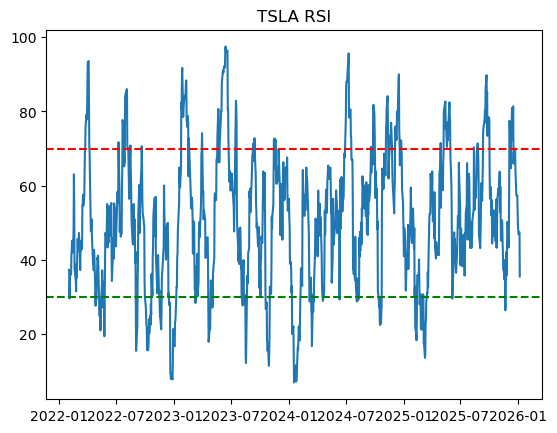

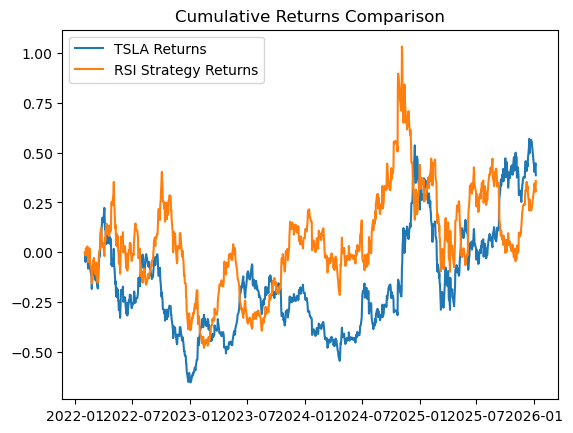

Price,Close,High,Low,Open,Volume,RSI,RSI_strategy,RSI_signal,Asset_returns,strategy_returns
Date,,,,,,,,,,
2025-12-22,488.730011,498.829987,485.329987,489.880005,86916100,69.959076,-1.0,NaN,0.565238,0.208832
2025-12-23,485.559998,491.970001,482.839996,489.399994,58223600,64.409801,-1.0,NaN,0.555086,0.216673
2025-12-24,485.399994,490.899994,476.799988,488.480011,41285400,62.146846,-1.0,NaN,0.554573,0.217074
2025-12-26,475.190002,489.089996,473.820007,485.230011,58780700,57.378848,-1.0,NaN,0.521874,0.242674
2025-12-29,459.640015,469.399994,459.000000,469.000000,66263000,57.324387,-1.0,NaN,0.472073,0.283339
2025-12-30,454.429993,463.119995,453.829987,461.089996,59238500,53.390444,-1.0,NaN,0.455387,0.297886
2025-12-31,449.720001,456.549988,449.299988,456.100006,49078000,49.359208,-1.0,NaN,0.440302,0.311338
2026-01-02,438.070007,458.339996,435.299988,457.799988,85535400,46.896111,-1.0,NaN,0.402991,0.345308
2026-01-05,451.670013,457.549988,444.570007,447.989990,67940800,47.461883,-1.0,NaN,0.446548,0.303543


In [2]:
ticker = "TSLA"
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = -1000

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def add_RSI(df, RSI_LENGTH):

    delta = df['Close'].diff()

    #separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    #calculate average gain and loss
    avg_gain = gain.rolling(window=RSI_LENGTH).mean()
    avg_loss = loss.rolling(window=RSI_LENGTH).mean()

    #calculate RSI
    rs = avg_gain / avg_loss 
    df['RSI'] = 100 - (100 / (1 + rs))

    #plot RSI
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red', linestyle='--')    
    plt.axhline(OVERSOLD, color='green', linestyle='--')
    plt.title(f'{ticker} RSI')

    return df.dropna()

def RSI_strategy(df, OVERBOUGHT, OVERSOLD):
    df['RSI_strategy'] = 0

    conditions = [
        (df['RSI'] > OVERBOUGHT), 
        (df['RSI'] < OVERSOLD)   ]
    choices = [-1, 1]
    
    df['RSI_signal'] = np.select(conditions, choices, default=np.nan)

    df['RSI_strategy'] = df['RSI_signal'].ffill()
    df['RSI_strategy'] = df['RSI_strategy'].fillna(0)
    df['RSI_strategy'] = df['RSI_strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['RSI_strategy']).cumprod() - 1
    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='RSI Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = add_RSI(df, RSI_LENGTH)
    df = RSI_strategy(df, OVERBOUGHT, OVERSOLD)
    df = test_strategy(df)
    
    return df

main().tail(10)

